# Notebook 4 - CIFAR-10 CNNs
In this notebook, GAN image sharpening transfer learning will be investigated using the CIFAR10 dataset. The image sharpening GAN that was trained on 75% of the cats vs dogs dataset in notebook 2, was used to sharpen a large fraction of the images from the CIFAR10 dataset in notebook 2B. In this notebook, it will be investigated if the 128x128 sharpened CIFAR10 images will result in higher neural network image classification accuracies compared to the original 32x32 low resolution CIFAR10 images.

Neural network classifier models will be trained on the original 32x32 CIFAR10 images and additional neural network classifiers will be trained on the same CIFAR10 images that have been sharpened to 128x128 pixels by the pretrained GAN in notebook 2B. Accuracy metrics across both groups of classifiers can be compared to investigate if image sharpening transfer learning has any effect on model performance. The LR 32x32 CIFAR10 data will be imported from noteboook 2B within this notebook and used to train the 32x32 low resolution (LR) models. The sharpened CIFAR10 super resolution (SR) images were created in notebook 2B, using GPU acceleration, and will be imported into this notebook environment. It will be verified that the datasets contain the same images and that the labels are correct and synchronised across both LR and SR images.

**Note:** The processor used for training the models in this notebook was a CPU.

# 1. Import Required Libraries

In [1]:
# Import libraries:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.layers import Input, Add, Dense, Activation, Flatten 
from tensorflow.keras.layers import LeakyReLU, Dropout, Add, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.losses import MeanSquaredError, BinaryCrossentropy, MeanAbsoluteError
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import cifar10
from sklearn.utils import shuffle
import time

In [2]:
# Print out the tensorflow version being used in this notebook environment:
print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.11.0


In [3]:
# Print out the processor being used for this notebook environment:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 285544528658272132
 xla_global_id: -1]

# 2. Load and Inspect the Input Data
The two datasets that will be used for training the neural network image classifiers in this notebook are:
* **Dataset 1:** 32x32 colour pixel LR CIFAR10 images, downloaded from tensorflow datasets within notebook 2B. This imported data from notebook 2B is alreaddy partitioned into train, validation and test partitions with 15,000, 5,000 and 10,000 images in each respectively. These partitioned datasets will be used to train the LR neural network classifiers.

* **Dataset 2:** 128x128 colour pixel SR CIFAR10 sharpened and already partitioned into train, validation and test partitions with 15,000, 5,000 and 10,000 images in each respectively. These datasets were imported into this notebook from notebook 2B. These partitioned datasets will be used to train the SR neural network classifiers.

In [4]:
# Display the files present in the notebook input directory from notebook 2B:
!ls -1 ../input/2b-sr-data-sharpening-v1

CIFAR10_x_test_32.npz
CIFAR10_x_train_32.npz
CIFAR10_x_val_32.npz
CIFAR10_y_test_32.npz
CIFAR10_y_train_32.npz
CIFAR10_y_val_32.npz
__notebook__.ipynb
__notebook_source__.ipynb
__output__.json
__results__.html
__results___files
custom.css
x_test_128_saved_10k.npz
x_train_128_saved_15k.npz
x_val_128_saved_5k.npz
y_test_128_labels_10k.npz
y_train_128_labels_15k.npz
y_val_128_labels_5k.npz


# 2.1 Load the Low Resolution (LR) CIFAR10 Data
The LR 32x32 CIFAR10 data will be loaded in from the output of notebook 2B and some metrics will be printed out to verify that the partitioned datasets look correct.

In [2]:
# Load in the LR 32x32 pixel CIFAR10 images within the train, validation and test segmented datasets:
x_train_32 = np.load('../input/2b-sr-data-sharpening-v1/CIFAR10_x_train_32.npz')
x_train_32 = x_train_32['arr_0']
x_val_32 = np.load('../input/2b-sr-data-sharpening-v1/CIFAR10_x_val_32.npz')
x_val_32 = x_val_32['arr_0']
x_test_32 = np.load('../input/2b-sr-data-sharpening-v1/CIFAR10_x_test_32.npz')
x_test_32 = x_test_32['arr_0']
# Load in the associated labels:
y_train_32 = np.load('../input/2b-sr-data-sharpening-v1/CIFAR10_y_train_32.npz')
y_train_32 = y_train_32["arr_0"]
y_val_32 = np.load('../input/2b-sr-data-sharpening-v1/CIFAR10_y_val_32.npz')
y_val_32 = y_val_32['arr_0']
y_test_32 = np.load('../input/2b-sr-data-sharpening-v1/CIFAR10_y_test_32.npz')
y_test_32 = y_test_32['arr_0']

In [ ]:
def class_counter(input_labels, name):  
    num_samples = len(input_labels)
    print("Total Number of elements in input dataset:", num_samples)
    classes = np.unique(input_labels)
    print("Dataset Unique Classes:", classes)
    class_counts = {}
    # Create the dictionary entries based on the number of classes in the input data:
    for element in classes:
        class_counts[element] = 0
    # Increment each created dictionary entry based on the input labels:
    for i in input_labels:
        class_counts[i.item()] += 1
    print(name, "class counts: \n", class_counts)
    return 

The cell below will count the classes in each dataset and also print out some metrics on the dataset shape and the minimum and maximum pixel values.

In [16]:
class_counter(y_train_32, "y_train_32")
print("--------------------------")
class_counter(y_val_32, "y_val_32")
print("--------------------------")
class_counter(y_test_32, "y_test_32")
print("--------------------------")

# Imported LR CIFAR10 data shapes:
print("-----Dataset shapes:-----")
print("x_train_32 shape:", np.shape(x_train_32))
print("y_train_32 shape:", np.shape(y_train_32))
print("----------------")
print("x_val_32 shape:", np.shape(x_val_32))
print("y_val_32 shape:", np.shape(y_val_32))
print("----------------")
print("x_test_32 shape: ", np.shape(x_test_32))
print("y_test_32 shape: ", np.shape(y_test_32))

print("-----Dataset Pixel values:-----")
print("x_train_32", "max:", np.max(x_train_32), ", min:", np.min(x_train_32))
print("x_val_32:  ", "max:", np.max(x_val_32), ", min:", np.min(x_val_32))
print("x_test_32:", "max:", np.max(x_test_32), ". min:", np.min(x_test_32))

Total Number of elements in input dataset: 15000
Dataset Unique Classes: [0 1 2 3 4 5 6 7 8 9]
y_train_32 class counts: 
 {0: 1500, 1: 1500, 2: 1500, 3: 1500, 4: 1500, 5: 1500, 6: 1500, 7: 1500, 8: 1500, 9: 1500}
--------------------------
Total Number of elements in input dataset: 5000
Dataset Unique Classes: [0 1 2 3 4 5 6 7 8 9]
y_val_32 class counts: 
 {0: 500, 1: 500, 2: 500, 3: 500, 4: 500, 5: 500, 6: 500, 7: 500, 8: 500, 9: 500}
--------------------------
Total Number of elements in input dataset: 10000
Dataset Unique Classes: [0 1 2 3 4 5 6 7 8 9]
y_test_32 class counts: 
 {0: 1000, 1: 1000, 2: 1000, 3: 1000, 4: 1000, 5: 1000, 6: 1000, 7: 1000, 8: 1000, 9: 1000}
--------------------------
-----Dataset shapes:-----
x_train_32 shape: (15000, 32, 32, 3)
y_train_32 shape: (15000, 1)
----------------
x_val_32 shape: (5000, 32, 32, 3)
y_val_32 shape: (5000, 1)
----------------
x_test_32 shape:  (10000, 32, 32, 3)
y_test_32 shape:  (10000, 1)
-----Dataset Pixel values:-----
x_train_32

From the output of the above cell, conducting an analysis of the detailed print out of some metrics on the various data subsets should give confidence that the imported data all looks correct. Here are the key observations:

* **1.** The labels for train, validation and test sets each contain equal representations of the 10 classes.
* **2.** All of the 32x32 CIFAR10 pixel LR images are within the range of [0,1].
* **3.** The LR partitioned image datasets contain the correct number of samples and the pixel dimensions look correct in each dataset.
* **4.** There is no way to verify that the labels match up to the images from the above information, so this will be verified along with the SR data in sections 2.4 to 2.6.

Finally, the 32x32 LR data labels will all be converted to one hot encoded format, as this is the required format for the TensorFlow neural network models.

In [3]:
# Convert the labels to one-hot encoded:
y_train = to_categorical(y_train_32)
y_val = to_categorical(y_val_32)
y_test = to_categorical(y_test_32)

# Print out a label from each partition to verify it looks correct:
print("y_train[0]:", y_train[0])
print("y_val[0]:", y_val[0])
print("y_test[0]:", y_test[0])

y_train[0]: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
y_val[0]: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
y_test[0]: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


# 2.2 Load the Super Resolution (SR) CIFAR10 Data
The GAN sharpened 128x128 SR CIFAR10 data that was created in notebook 2B will be downloaded into this notebook environment in the cell below.

In [4]:
# Load in the sharpened 128x128 pixel CIFAR10 images within the train, validation and test segmented datasets:
x_train_128 = np.load('../input/2b-sr-data-sharpening-v1/x_train_128_saved_15k.npz')
x_train_128 = x_train_128['arr_0']
x_val_128 = np.load('../input/2b-sr-data-sharpening-v1/x_val_128_saved_5k.npz')
x_val_128 = x_val_128['arr_0']
x_test_128 = np.load('../input/2b-sr-data-sharpening-v1/x_test_128_saved_10k.npz')
x_test_128 = x_test_128['arr_0']
# Load in the associated labels:
y_train_128 = np.load('../input/2b-sr-data-sharpening-v1/y_train_128_labels_15k.npz')
y_train_128 = y_train_128["arr_0"]
y_val_128 = np.load('../input/2b-sr-data-sharpening-v1/y_val_128_labels_5k.npz')
y_val_128 = y_val_128['arr_0']
y_test_128 = np.load('../input/2b-sr-data-sharpening-v1/y_test_128_labels_10k.npz')
y_test_128 = y_test_128['arr_0']

In [5]:
# Convert the labels to one-hot encoded:
y_train_128 = to_categorical(y_train_128)
y_val_128 = to_categorical(y_val_128)
y_test_128 = to_categorical(y_test_128)

The loaded data contains associated labels for the sake of completeness, but these should be the exact same labels as already imported into this notebook for the 32x32 LR dataset. A quick check should verify this and allow the LR labels to be used for all of the SR neural network models also. This check will be performed in the next cell.

In [12]:
print("Is y_train equal to y_train_128 across all elements? -",(y_train==y_train_128).all())
print("Is y_val equal to y_val_128 across all elements?     -",(y_val==y_val_128).all())
print("Is y_test equal to y_test_128 across all elements?   -",(y_test==y_test_128).all())

Is y_train equal to y_train_128 across all elements? - True
Is y_val equal to y_val_128 across all elements?     - True
Is y_test equal to y_test_128 across all elements?   - True


From the output of the above cell, it has been shown that the LR labels are exactly the same as the SR labels, giving more confidence in the datasets being synchronised.

Next, some metrics will be printed out for the LR and SR datasets for all partitioned datasets and labels, to help verify that all of the datasets look correct. Some of the metrics are repeated from above for completeness sake.

In [17]:
# Print out the shapes of all of the segmented datasets so these can be verified:
print("x_train_32 shape: ", np.shape(x_train_32), ", max:", np.max(x_train_32), ", min:", np.min(x_train_32))
print("x_train_128 shape:", np.shape(x_train_128), ", max:", np.max(x_train_128), ", min:", np.min(x_train_128))
print("y_train shape:    ", np.shape(y_train))
print("--------------------------")
print("x_val_32 shape: ", np.shape(x_val_32), ", max:", np.max(x_val_32), ", min:", np.min(x_val_32))
print("x_val_128 shape:", np.shape(x_val_128), ", max:", np.max(x_val_128), ", min:", np.min(x_val_128))
print("y_val shape:    ", np.shape(y_val))
print("--------------------------")
print("x_test_32 shape: ", np.shape(x_test_32), ", max:", np.max(x_test_32), ", min:", np.min(x_test_32))
print("x_test_128 shape:", np.shape(x_test_128), ", max:", np.max(x_test_128), ", min:", np.min(x_test_128))
print("y_test shape:    ", np.shape(y_test))

x_train_32 shape:  (15000, 32, 32, 3) , max: 1.0 , min: 0.0
x_train_128 shape: (15000, 128, 128, 3) , max: 1.0 , min: 0.0
y_train shape:     (15000, 10)
--------------------------
x_val_32 shape:  (5000, 32, 32, 3) , max: 1.0 , min: 0.0
x_val_128 shape: (5000, 128, 128, 3) , max: 1.0 , min: 0.0
y_val shape:     (5000, 10)
--------------------------
x_test_32 shape:  (10000, 32, 32, 3) , max: 1.0 , min: 0.0
x_test_128 shape: (10000, 128, 128, 3) , max: 1.0 , min: 0.0
y_test shape:     (10000, 10)


Everything looks satisfactory to proceed, based on the output from the cell above: dataset shapes look correct and pixel values are in the range [0,1]. 

Next, 10 random images will be shown from the train, validation and test datsets for the LR and SR data, along with the associated labels. This should verify that all LR and SR partioned datasets contain the same images, which will then allow meaningful comparisons to be made between the performance of the LR and SR neural network models. 

# 2.3 Plotting of Images for Verification
A random sample of 10 images will be shown from each of the LR and SR datasets, along with the associated labels, to confirm from the sample set that the images and labels are synchronised across all datasets.

In [11]:
# Create a dictionary of the CIFAR10 associated label names:
cifar10_label_names = {0:"Airplane", 1:"Automobile", 2:"Bird", 3:"Cat", 4:"Deer", 5:"Dog",
                       6:"Frog", 7:"Horse", 8:"Ship", 9:"Truck"}

# 2.4 Training Data Visualisation
10 random images from the LR and SR training data and associated labels will be shown in the cell below.

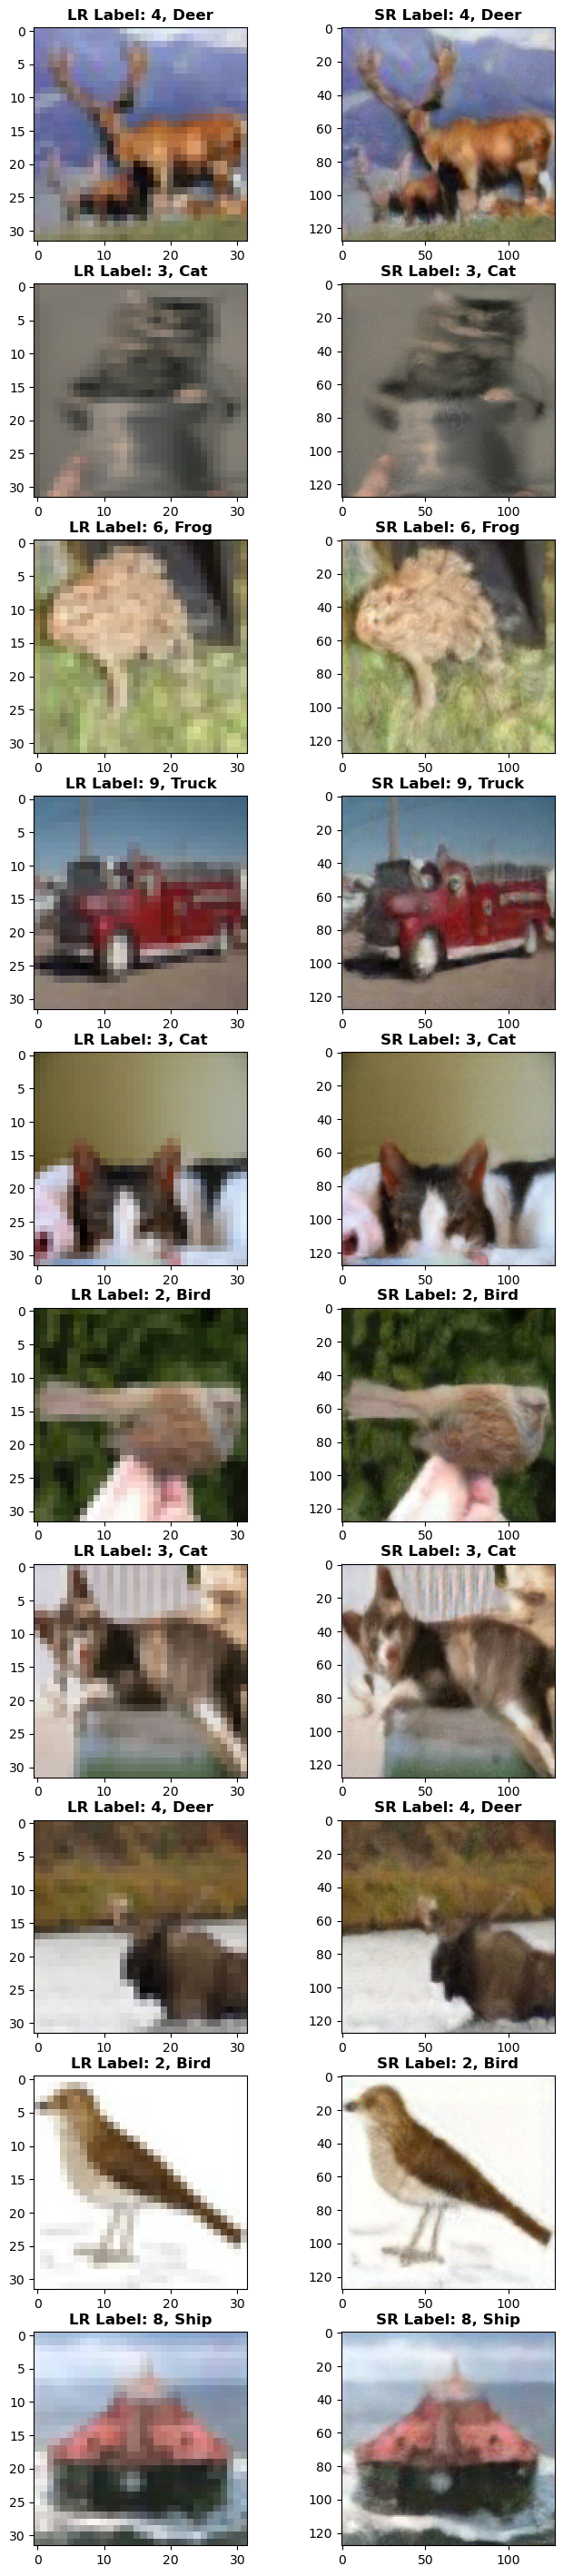

In [13]:
# Plot some of the training data and associated labels:   
fig, ax = plt.subplots(nrows=6,ncols=2, figsize=(8,36))
np.random.seed(78890)
for image in range(0, 19, 2):
    random_train_index = int(np.random.randint(low = 1, high = len(y_test), size = 1))
    plt.subplot(10,2,image+1)
    plt.imshow(x_train_32[random_train_index])
    label = int(np.argmax(y_train[random_train_index])) # As y_train is onehot encoded
    label_text = cifar10_label_names[label]
    plt.title("LR Label: {}, {}".format(label, label_text), fontsize=12, fontweight='bold')
    plt.subplot(10,2,image+2)
    plt.imshow(x_train_128[random_train_index])
    plt.title("SR Label: {}, {}".format(label, label_text), fontsize=12, fontweight='bold')

# 2.5 Validation Data Visualisation
10 random images from the LR and SR validation data and associated labels will be shown in the cell below.

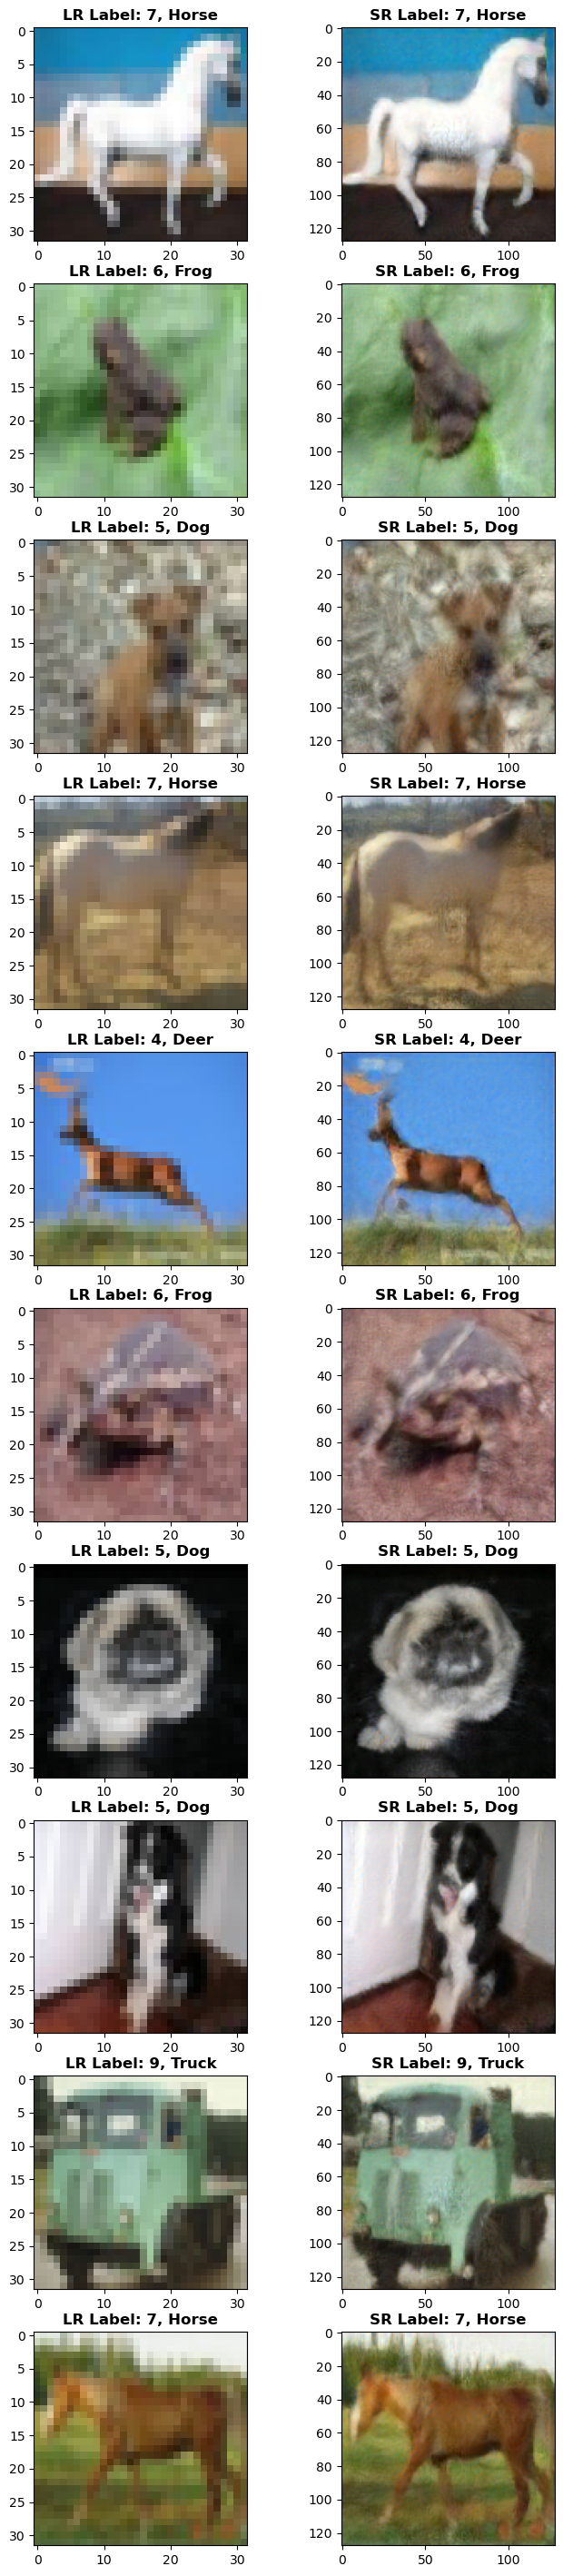

In [14]:
# Plot some of the validation data and associated labels:   
fig, ax = plt.subplots(nrows=6,ncols=2, figsize=(8, 36))
np.random.seed(78890)
for image in range(0, 19, 2):
    random_val_index = int(np.random.randint(low = 1, high = len(y_val), size = 1))
    plt.subplot(10,2,image+1)
    plt.imshow(x_val_32[random_val_index])
    label = int(np.argmax(y_val[random_val_index])) # As y_val is onehot encoded
    label_text = cifar10_label_names[label]
    plt.title("LR Label: {}, {}".format(label, label_text), fontsize=12, fontweight='bold')
    plt.subplot(10,2,image+2)
    plt.imshow(x_val_128[random_val_index])
    plt.title("SR Label: {}, {}".format(label, label_text), fontsize=12, fontweight='bold')

# 2.6 Test Data Visualisation
10 random images from the LR and SR test data and associated labels will be shown in the cell below.

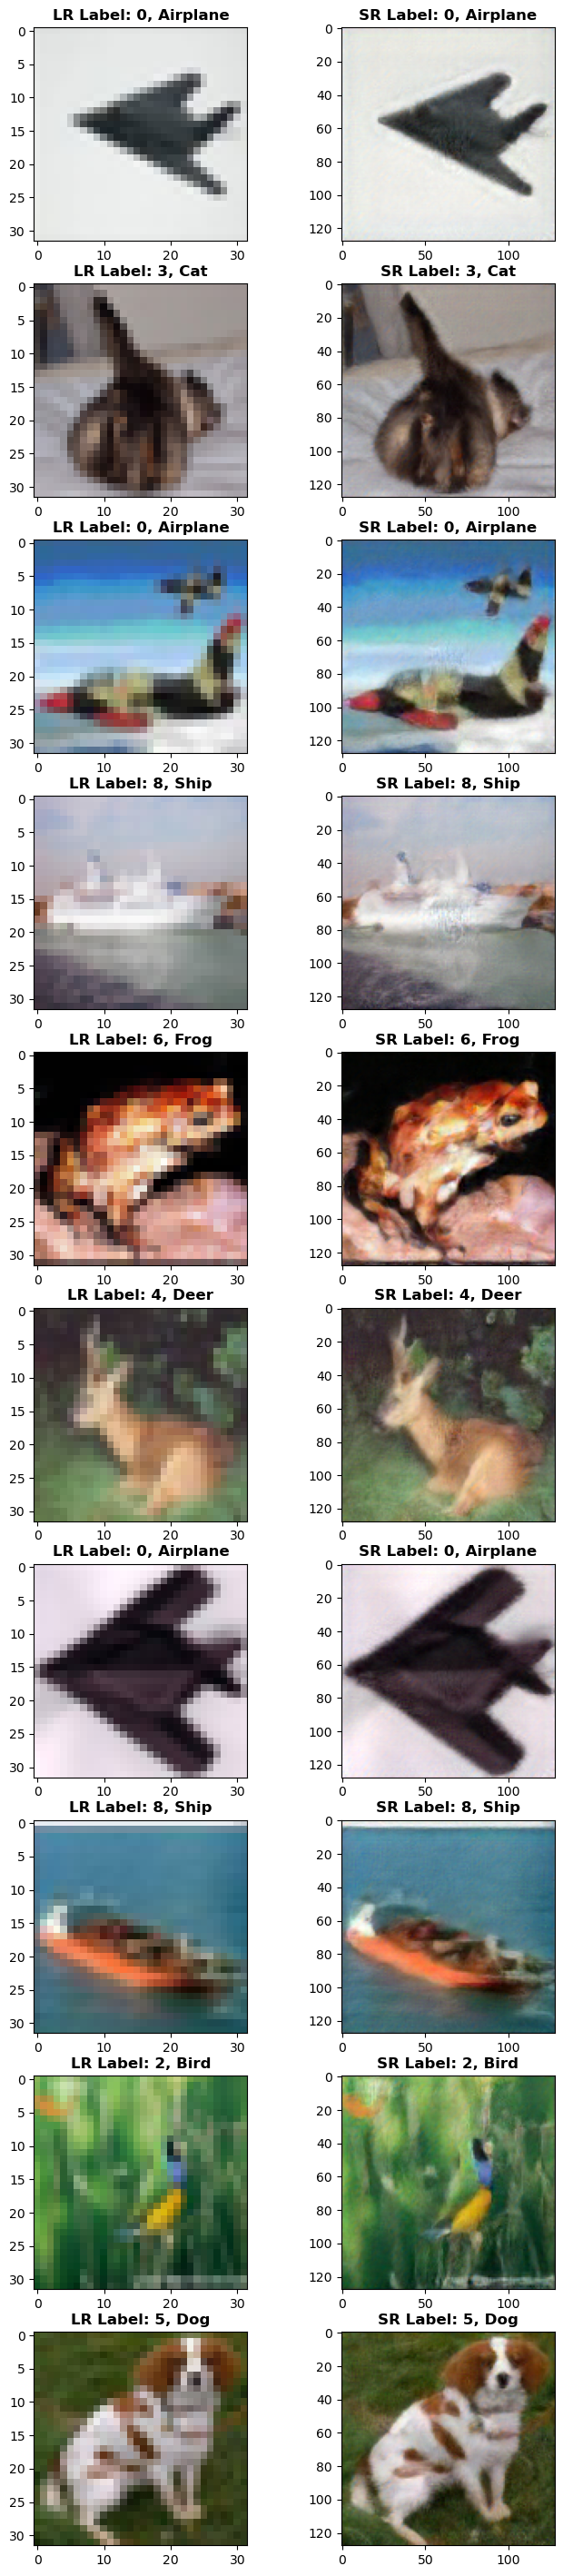

In [23]:
# Plot some of the test data and associated labels:   
fig, ax = plt.subplots(nrows=6,ncols=2, figsize=(8,36))
np.random.seed(78890)
for image in range(0, 19, 2):
    random_test_index = int(np.random.randint(low = 1, high = len(y_test), size = 1))
    plt.subplot(10,2,image+1)
    plt.imshow(x_test_32[random_test_index])
    label = int(np.argmax(y_test[random_test_index])) # As y_test is onehot encoded
    label_text = cifar10_label_names[label]
    plt.title("LR Label: {}, {}".format(label, label_text), fontsize=12, fontweight='bold')
    plt.subplot(10,2,image+2)
    plt.imshow(x_test_128[random_test_index])
    plt.title("SR Label: {}, {}".format(label, label_text), fontsize=12, fontweight='bold')

From the above plots from the LR and SR three subsets; training, validation and test, it is clear that the data and labels are synchronised across all datsets. Each of the 10 randomly sampled images from the three datasets contain the correct image, according to the labels. This verifies that the images and labels are synchronised across all LR and SR datasets.

Next, the LR 32x32 CIFAR10 neural network image classifier models will be trained.

# 3. Low Resolution (LR) CIFAR10 Neural Network Image Classifiers
The 32x32 pixel LR neuural network image classifiers will be trained on the CIFAR10 dataset in this section.

In [16]:
def model_plots(history_dict):
    """
    Requirements:
    This function requires that matplotlib.pyplot is imported as "plt".
    
    Inputs:
    (1) TensorFlow model history dictionary.
    
    Returns: Nothing.
    
    Prints:
    (1) Two plots: 
    - Plot 1 displays the training accuracy and validation accuracy over each training epoch.
    - Plot 2 displays the training loss and validation loss over each training epoch.
    """
    # Left hand side plot: 
    plt.subplots(1,2, figsize = (13,6))
    acc = history_dict['acc']
    val_acc = history_dict['val_acc']   
    epochs = range(1, len(acc) + 1)
    plt.subplot(1,2,1)
    red_dash = 'r--'
    green_solid = 'g'
    plt.plot(epochs, acc, red_dash, label = 'Training Accuracy')
    plt.plot(epochs, val_acc, green_solid, label = 'Validation Accuracy')
    plt.title('Training & Validation Accuracy \n', fontsize = "18", fontweight="bold")
    plt.xlabel('Epochs', fontsize = "13")
    plt.ylabel('Accuracy', fontsize = "13")
    plt.legend()
    plt.grid()
    
    # Right hand side plot:
    plt.subplot(1,2,2)
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, red_dash, label = 'Training Loss')
    plt.plot(epochs, val_loss, green_solid, label = 'Validation Loss')
    plt.title('Training & Validation Loss \n', fontsize = "18", fontweight="bold")
    plt.xlabel('Epochs', fontsize = "13")
    plt.ylabel('Loss', fontsize = "13")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()
    return

# 3.1. Training the First Neural Network Classifier Models on the LR 32x32 Pixel Data
Here the first neural network classifiers will created and these will be trained using the 32x32 pixel balanced CIFAR10 datasets. 

In [8]:
# Classifier for original LR 32x32 CIFAR-10 dataset:
cifar_model_1 = models.Sequential()
cifar_model_1.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
cifar_model_1.add(layers.MaxPooling2D((2, 2)))
cifar_model_1.add(layers.Conv2D(64, (3, 3), activation='relu'))
cifar_model_1.add(layers.MaxPooling2D((2, 2)))
cifar_model_1.add(layers.Conv2D(128, (3, 3), activation='relu'))
cifar_model_1.add(layers.MaxPooling2D((2, 2)))
cifar_model_1.add(layers.Flatten()) 
cifar_model_1.add(layers.Dense(256, activation='relu'))
cifar_model_1.add(layers.Dense(10, activation='softmax'))
cifar_model_1.summary()

cifar_model_1.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 512)               0

In [20]:
cifar_history_1 = cifar_model_1.fit(x_train_32, y_train, epochs=100, batch_size=50,
                              validation_data = (x_val_32, y_val), shuffle=True)
# Save the model:
cifar_model_1.save('32_LR_100e_cifar_model_1.h5')

2023-02-09 23:37:39.547513: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
300/300 [==============================] - 11s 34ms/step - loss: 2.1228 - acc: 0.2311 - val_loss: 1.9851 - val_acc: 0.2846
Epoch 2/100
300/300 [==============================] - 12s 39ms/step - loss: 1.9011 - acc: 0.3150 - val_loss: 1.8611 - val_acc: 0.3122
Epoch 3/100
300/300 [==============================] - 10s 34ms/step - loss: 1.7660 - acc: 0.3658 - val_loss: 1.7279 - val_acc: 0.3758
Epoch 4/100
300/300 [==============================] - 10s 33ms/step - loss: 1.6693 - acc: 0.3955 - val_loss: 1.6324 - val_acc: 0.4042
Epoch 5/100
300/300 [==============================] - 11s 36ms/step - loss: 1.5957 - acc: 0.4240 - val_loss: 1.6036 - val_acc: 0.4250
Epoch 6/100
300/300 [==============================] - 10s 33ms/step - loss: 1.5445 - acc: 0.4417 - val_loss: 1.5624 - val_acc: 0.4358
Epoch 7/100
300/300 [==============================] - 10s 34ms/step - loss: 1.4999 - acc: 0.4601 - val_loss: 1.5081 - val_acc: 0.4682
Epoch 8/100
300/300 [==============================] - 

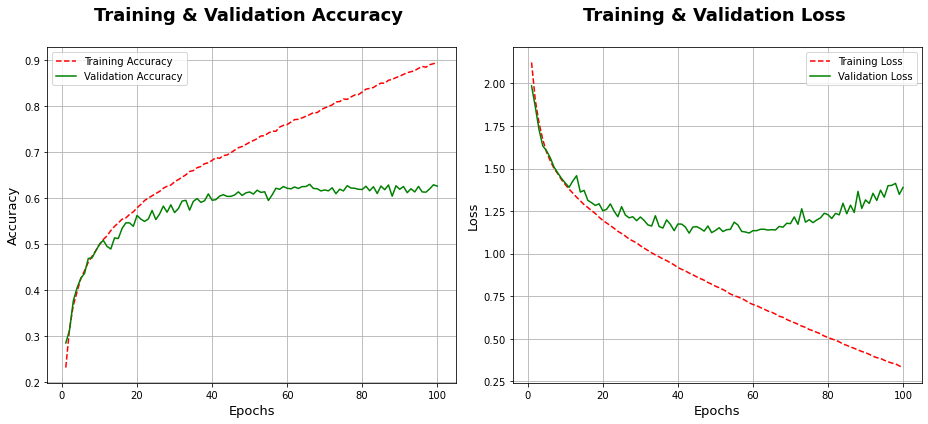

In [21]:
model_plots(cifar_history_1.history)

In [38]:
# Retrain model_1 so to just before it starts overfitting at 59 epochs:
cifar_model_1B = models.Sequential()
# L1:
cifar_model_1B.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
cifar_model_1B.add(layers.MaxPooling2D((2, 2)))
# L2:
cifar_model_1B.add(layers.Conv2D(64, (3, 3), activation='relu'))
cifar_model_1B.add(layers.MaxPooling2D((2, 2)))
# L3:
cifar_model_1B.add(layers.Conv2D(128, (3, 3), activation='relu'))
cifar_model_1B.add(layers.MaxPooling2D((2, 2)))
# L4:
cifar_model_1B.add(layers.Flatten()) 
cifar_model_1B.add(layers.Dense(256, activation='relu'))
cifar_model_1B.add(layers.Dense(10, activation='softmax'))
cifar_model_1B.summary()

cifar_model_1B.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])
cifar_history_1B = cifar_model_1B.fit(x_train_32, y_train, epochs=59, batch_size=50,
                              validation_data = (x_val_32, y_val), shuffle=True)
# Save the model:
cifar_model_1B.save('32_LR_59e_cifar_model_1B.h5')

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 4, 4, 128)         73856     
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 2, 2, 128)         0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 512)              

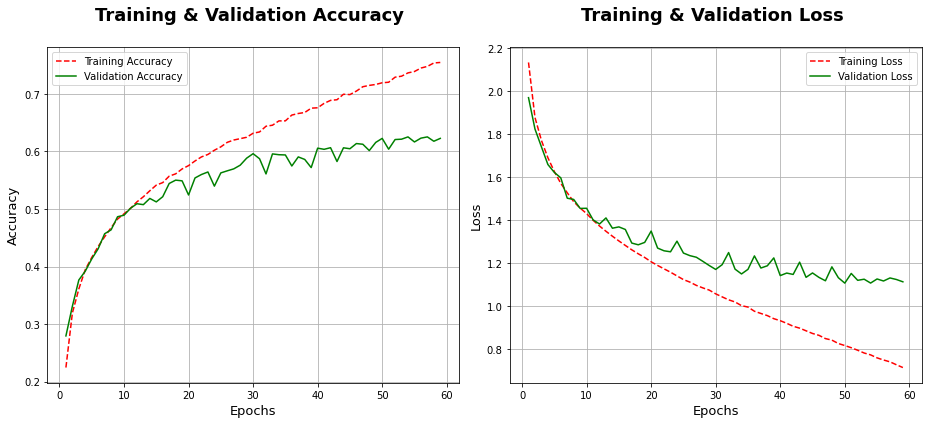

313/313 [==============================] - 4s 11ms/step - loss: 1.1183 - acc: 0.6215


[1.1182518005371094, 0.6215000152587891]

In [39]:
model_plots(cifar_history_1B.history)

# Evaluate the trained model on the test set:
cifar_model_1B.evaluate(x_test_32, y_test)

# 3.2 Applying Regularisation to the LR CIFAR10 Model
Next, regularisation will be applied to the previous 32x32 CIFAR10 LR model, to investigate if this leads to improved performance. 

In [21]:
# Train initially for 150 epochs:
cifar_model_1C = models.Sequential()
cifar_model_1C.add(layers.Conv2D(32, (3, 3), activation='relu',input_shape=(32, 32, 3)))
cifar_model_1C.add(layers.MaxPooling2D((2, 2)))
cifar_model_1C.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer = tf.keras.regularizers.l2(l=0.01)))
cifar_model_1C.add(layers.MaxPooling2D((2, 2)))
cifar_model_1C.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer = tf.keras.regularizers.l2(l=0.01)))
cifar_model_1C.add(layers.MaxPooling2D((2, 2)))
cifar_model_1C.add(layers.Flatten()) 
cifar_model_1C.add(layers.Dense(256, activation='relu', kernel_regularizer = tf.keras.regularizers.l2(l=0.01)))
cifar_model_1C.add(layers.Dense(10, activation='softmax'))
cifar_model_1C.summary()

cifar_model_1C.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])

cifar_history_1C = cifar_model_1C.fit(x_train_32, y_train, batch_size=50,
         validation_data = (x_val_32, y_val), epochs=150, shuffle=True)

# Save the model:
cifar_model_1C.save('32_LR_150e_cifar_model_1C_L2.h5')

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 4, 4, 128)         73856     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 2, 2, 128)         0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 512)              

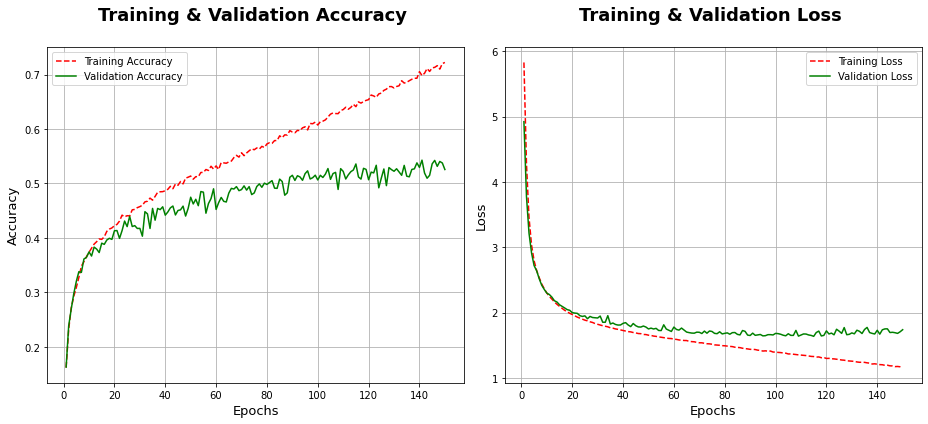

In [22]:
model_plots(cifar_history_1C.history)

In [15]:
# Retrain the previous model to just before before overfitting starts at 115 epochs:
cifar_model_1D = models.Sequential()
cifar_model_1D.add(layers.Conv2D(32, (3, 3), activation='relu',input_shape=(32, 32, 3)))
cifar_model_1D.add(layers.MaxPooling2D((2, 2)))
cifar_model_1D.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer = tf.keras.regularizers.l2(l=0.01)))
cifar_model_1D.add(layers.MaxPooling2D((2, 2)))
cifar_model_1D.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer = tf.keras.regularizers.l2(l=0.01)))
cifar_model_1D.add(layers.MaxPooling2D((2, 2)))
cifar_model_1D.add(layers.Flatten()) 
cifar_model_1D.add(layers.Dense(256, activation='relu', kernel_regularizer = tf.keras.regularizers.l2(l=0.01)))
cifar_model_1D.add(layers.Dense(10, activation='softmax'))
cifar_model_1D.summary()

cifar_model_1D.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])

cifar_history_1D = cifar_model_1D.fit(x_train_32, y_train, batch_size=50,
         validation_data = (x_val_32, y_val), epochs=115, shuffle=True)

# Save the model:
cifar_model_1D.save('32_LR_115e_cifar_model_1D_L2.h5')

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 4, 4, 128)         73856     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 2, 2, 128)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 512)              

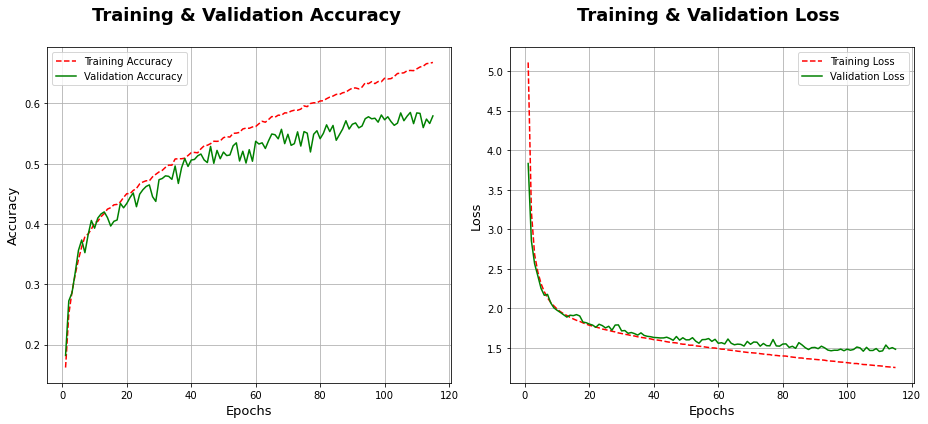

In [18]:
model_plots(cifar_history_1D.history)

In [19]:
# Evaluate the model on the test data:
cifar_model_1D.evaluate(x_test_32, y_test)

313/313 [==============================] - 3s 9ms/step - loss: 1.4776 - acc: 0.5782


[1.47756826877594, 0.5781999826431274]

# 3.3 Increasing the Convolution Size of the LR Model
Next, it will be investigated if increasing the convolution size from (3,3) to the maximum size the LR model will allow, results in increased model performance.

In [12]:
# Classifier for original 32x32 CIFAR-10 dataset, investigating a (5,5) conv filter:
cifar_model_2 = models.Sequential()
# L1:
cifar_model_2.add(layers.Conv2D(32, (5, 5), activation='relu', input_shape=(32, 32, 3)))
cifar_model_2.add(layers.MaxPooling2D((2, 2)))
# L2:
cifar_model_2.add(layers.Conv2D(64, (5, 5), activation='relu'))
cifar_model_2.add(layers.MaxPooling2D((2, 2)))
# L3:
cifar_model_2.add(layers.Conv2D(128, (3, 3), activation='relu'))
cifar_model_2.add(layers.MaxPooling2D((2, 2)))
# L4:
cifar_model_2.add(layers.Flatten()) 
cifar_model_2.add(layers.Dense(256, activation='relu'))
cifar_model_2.add(layers.Dense(10, activation='softmax'))
cifar_model_2.summary()

cifar_model_2.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])
cifar_history_2 = cifar_model_2.fit(x_train_32, y_train, epochs=100, batch_size=50,
                              validation_data = (x_val_32, y_val), shuffle=True)
# Save the model:
cifar_model_2.save('32_LR_100e_cifar_model_2.h5')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 32)        2432      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 10, 64)        51264     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 3, 3, 128)         73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 1, 1, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 128)              

2023-02-10 08:28:41.626835: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
300/300 [==============================] - 12s 38ms/step - loss: 2.1312 - acc: 0.2078 - val_loss: 1.9857 - val_acc: 0.2870
Epoch 2/100
300/300 [==============================] - 13s 42ms/step - loss: 1.9138 - acc: 0.2924 - val_loss: 1.8649 - val_acc: 0.3056
Epoch 3/100
300/300 [==============================] - 11s 37ms/step - loss: 1.8226 - acc: 0.3312 - val_loss: 1.8076 - val_acc: 0.3362
Epoch 4/100
300/300 [==============================] - 11s 36ms/step - loss: 1.7556 - acc: 0.3594 - val_loss: 1.7198 - val_acc: 0.3684
Epoch 5/100
300/300 [==============================] - 12s 41ms/step - loss: 1.6981 - acc: 0.3829 - val_loss: 1.7006 - val_acc: 0.3844
Epoch 6/100
300/300 [==============================] - 11s 38ms/step - loss: 1.6470 - acc: 0.4050 - val_loss: 1.6424 - val_acc: 0.4038
Epoch 7/100
300/300 [==============================] - 11s 36ms/step - loss: 1.6085 - acc: 0.4174 - val_loss: 1.5858 - val_acc: 0.4250
Epoch 8/100
300/300 [==============================] - 

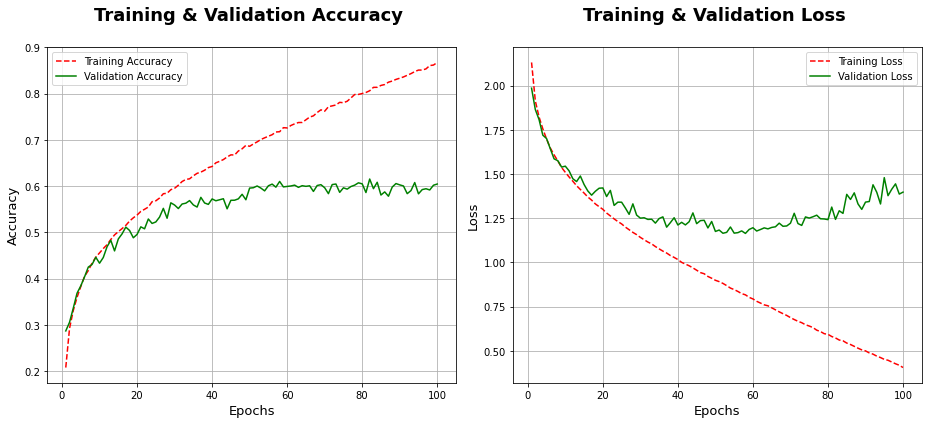

In [13]:
model_plots(cifar_history_2.history)

In [20]:
# Retrain the larger conv model to just before it starts overfitting at 58 epochs:
cifar_model_2B = models.Sequential()
# L1:
cifar_model_2B.add(layers.Conv2D(32, (5, 5), activation='relu', input_shape=(32, 32, 3)))
cifar_model_2B.add(layers.MaxPooling2D((2, 2)))
# L2:
cifar_model_2B.add(layers.Conv2D(64, (5, 5), activation='relu'))
cifar_model_2B.add(layers.MaxPooling2D((2, 2)))
# L3:
cifar_model_2B.add(layers.Conv2D(128, (3, 3), activation='relu'))
cifar_model_2B.add(layers.MaxPooling2D((2, 2)))
# L4:
cifar_model_2B.add(layers.Flatten()) 
cifar_model_2B.add(layers.Dense(10, activation='softmax'))
cifar_model_2B.summary()

cifar_model_2B.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])
cifar_history_2B = cifar_model_2B.fit(x_train_32, y_train, epochs=58, batch_size=50,
                              validation_data = (x_val_32, y_val), shuffle=True)
# Save the model:
cifar_model_2B.save('32_LR_58e_cifar_model_2B.h5')

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 28, 28, 32)        2432      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 10, 10, 64)        51264     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 3, 3, 128)         73856     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 1, 1, 128)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 128)              

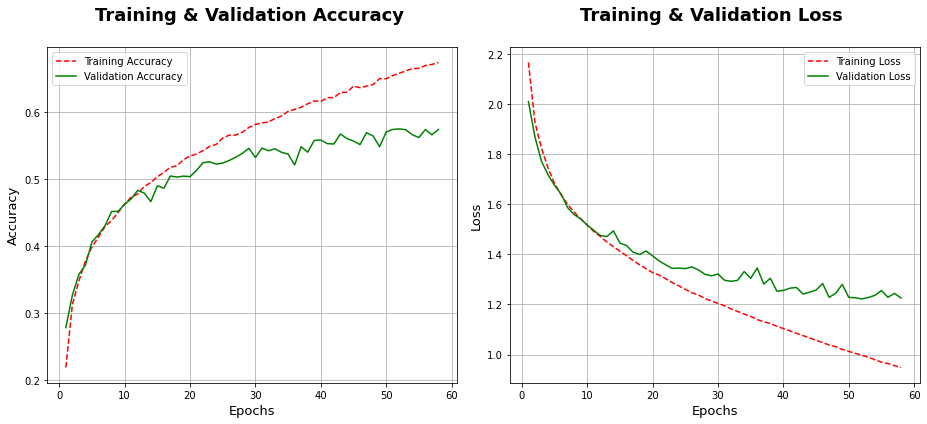

313/313 [==============================] - 4s 11ms/step - loss: 1.2325 - acc: 0.5740


[1.2325202226638794, 0.5740000009536743]

In [22]:
model_plots(cifar_history_2B.history)

# Evaluate the model on the test data:
cifar_model_2B.evaluate(x_test_32, y_test)

# 4. Training Models on the 128x128 Pixel Super Resolution (SR) CIFAR10 Image Data
In this sectinon, the GAN sharpened super resolution (SR) CIFAR10 image data will be used to train another set of neural network classifier models. These models have an extra layer added due to the 4x increase in image size. Additionally, the convolution size was also increased to (6,6) from (3,3) due to the increased image size.
Firstly, a convolutional model builder function will be implemented in the next cell.

In [17]:
def conv_model(input_shape, conv, L1_units, L2_units, L3_units, L4_units, L5_units, max_pooling, regularize, optimiser):
    """
    Inputs:
    (1) input_shape: specifies the input shape of the images for the neural network.
    (2) conv: specifies the size of the convolution window pixels.
    (3) L1_units: An integer input that dictates the number of units in layer 1 of the CNN.
    (4) L2_units: An integer input that dictates the number of units in layer 2 of the CNN.
    (5) L3_units: An integer input that dictates the number of units in layer 3 of the CNN.
    (6) L4_units: An integer input that dictates the number of units in layer 4 of the CNN.
    (7) L5_units: 
    (8) max_pooling: A Boolean input that dictates if max pooling is added to the end of layers 1,2 & 3 
        of the of the CNN.
    (9) regularize: A Boolean input that dictates if the model is regualrised. Options for this are: 
        - "L1" for L1 regularisation,
        - "L2"for L2 regularisation,
        - "dropout" for dropout to be added.
    (10) optimizer: A string input that will specifify the optimiser for the created model. For example this input might be "rmsprop" or "adam".

    Returns:
    (1) Compiled convolutional neural network (NN) model.

    Prints:
    (1) A summary of the created convolutional NN model.

    """
    # Create the conv sequential model:
    conv_model = models.Sequential()

    # Layer 1: (input layer)
    conv_model.add(layers.Conv2D(L1_units, (conv,conv), activation='relu', input_shape=input_shape))
    if max_pooling==True:
        conv_model.add(layers.MaxPooling2D((2,2)))
        print("L1 Pooling")

    # Layer 2: (allowed: max_pooling & dropout only):
    if regularize==False: 
        conv_model.add(layers.Conv2D(L2_units, (conv,conv), activation='relu'))
    elif regularize=="dropout":
        conv_model.add(layers.Conv2D(L2_units, (conv,conv), activation='relu'))
        conv_model.add(tf.keras.layers.Dropout(0.2))
    else:
        conv_model.add(layers.Conv2D(L2_units, (conv,conv), activation='relu'))
    if max_pooling==True:
        conv_model.add(layers.MaxPooling2D((2,2)))

    # Layer 3: (allowed: max_pooling, dropout & L1/L2 regularisation)
    if regularize == 'L1':
        conv_model.add(layers.Conv2D(L3_units, (conv,conv), activation='relu', kernel_regularizer = tf.keras.regularizers.l1(l=0.01)))
    elif regularize == 'L2':
        conv_model.add(layers.Conv2D(L3_units, (conv,conv), activation='relu', kernel_regularizer = tf.keras.regularizers.l2(l=0.01)))
    elif regularize == "dropout":
        conv_model.add(layers.Conv2D(L3_units, (conv,conv), activation='relu'))
        conv_model.add(tf.keras.layers.Dropout(0.2))
    else:
        conv_model.add(layers.Conv2D(L3_units, (conv,conv), activation='relu'))

    if max_pooling == True:
        conv_model.add(layers.MaxPooling2D((2,2)))
    else:
        next
    
        # Layer 4: (allowed: max_pooling, dropout & L1/L2 regularisation)
    if regularize == 'L1':
        conv_model.add(layers.Conv2D(L4_units, (conv,conv), activation='relu', kernel_regularizer = tf.keras.regularizers.l1(l=0.01)))
    elif regularize == 'L2':
        conv_model.add(layers.Conv2D(L4_units, (conv,conv), activation='relu', kernel_regularizer = tf.keras.regularizers.l2(l=0.01)))
    elif regularize == "dropout":
        conv_model.add(layers.Conv2D(L4_units, (conv,conv), activation='relu'))
        conv_model.add(tf.keras.layers.Dropout(0.2))
    else:
        conv_model.add(layers.Conv2D(L4_units, (conv,conv), activation='relu'))

    if max_pooling == True:
        conv_model.add(layers.MaxPooling2D((2,2)))
    else:
        next
    
    #Flatten the output so it can be passed into a Dense layer:
    conv_model.add(layers.Flatten())

    # layer 5: (Dense Layer) (allowed: dropout & L1/L2 regularisation only)
    if regularize == 'L1':
        conv_model.add(layers.Dense(L5_units, activation='relu', kernel_regularizer = tf.keras.regularizers.l1(l=0.01)))
    elif regularize == 'L2':
        conv_model.add(layers.Dense(L5_units, activation='relu', kernel_regularizer = tf.keras.regularizers.l2(l=0.01)))
    elif regularize == 'dropout':
        conv_model.add(layers.Dense(L5_units, activation='relu'))
        conv_model.add(tf.keras.layers.Dropout(0.2))
    else:
        conv_model.add(layers.Dense(L5_units, activation='relu'))

    # layer 6: (Output Dense Layer)
    conv_model.add(layers.Dense(10, activation='softmax'))

    conv_model.compile(optimizer = optimiser,
                  loss = 'categorical_crossentropy',
                  metrics = ['acc'])

    conv_model.summary()
    return conv_model


# 4.1 SR CIFAR10 Model Without Regularisation
The deep convolutional neural network model architecture will be the same as was used for the SR cats vs dogs data in notebook 3.

In [13]:
optimiser = optimizers.RMSprop(learning_rate=1e-04)
cifar_model_3 = conv_model(input_shape=(128,128,3), conv=6, L1_units=50, L2_units=64, L3_units=128, 
                        L4_units=128, L5_units=700, max_pooling=True, regularize=False, optimiser=optimiser)

cifar_history_3 = cifar_model_3.fit(x_train_128, y_train, batch_size=50,
         validation_data = (x_val_128, y_val), epochs=20, shuffle=True)

# Save the model:
cifar_model_3.save('128_SR_20e_cifar_model_3.h5')

L1 Pooling
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 123, 123, 50)      5450      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 61, 61, 50)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 56, 56, 64)        115264    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 23, 23, 128)       295040    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 11, 11, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 6, 6, 1

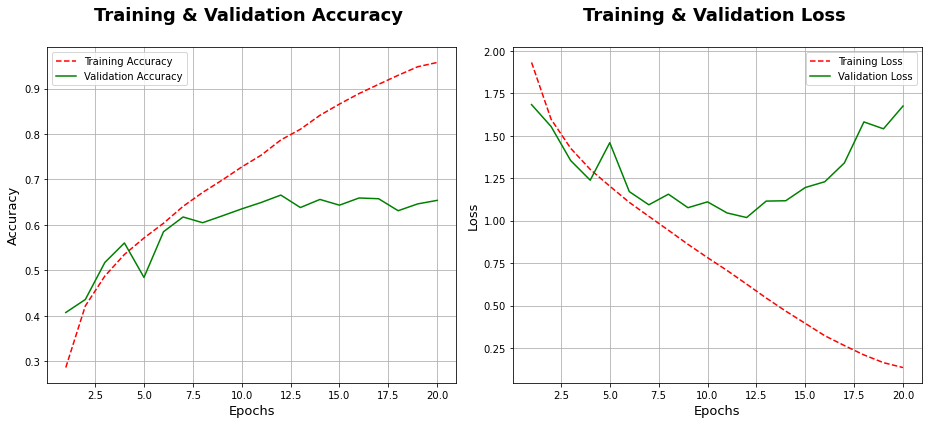

In [15]:
# Plot the model training and validation accuracies and loss over each epoch:
model_plots(cifar_history_3.history)

In [16]:
# Retrain the previous model to just before it starts overfitting at 12 epochs:
optimiser = optimizers.RMSprop(learning_rate=1e-04)
cifar_model_3B = conv_model(input_shape=(128,128,3), conv=6, L1_units=50, L2_units=64, L3_units=128, 
                        L4_units=128, L5_units=700, max_pooling=True, regularize=False, optimiser=optimiser)

cifar_history_3B = cifar_model_3B.fit(x_train_128, y_train, batch_size=50,
         validation_data = (x_val_128, y_val_128), epochs=12, shuffle=True)

# Save the model:
cifar_model_3B.save('128_SR_12e_cifar_model_3B.h5')

L1 Pooling
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 123, 123, 50)      5450      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 61, 61, 50)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 56, 64)        115264    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 28, 28, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 23, 23, 128)       295040    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 11, 11, 

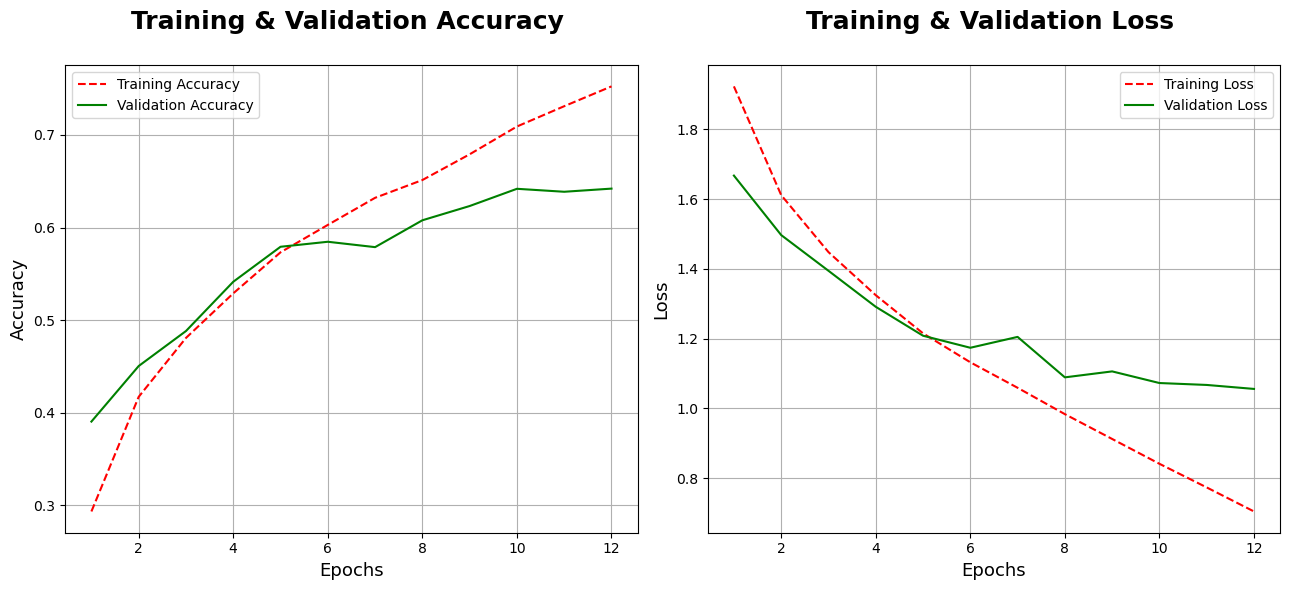

In [17]:
model_plots(cifar_history_3B.history)

In [18]:
# Evaluate this model on the test data:
cifar_model_3B.evaluate(x_test_128, y_test)

313/313 [==============================] - 155s 493ms/step - loss: 1.0725 - acc: 0.6366


[1.0725464820861816, 0.6366000175476074]

# 4.2 Adding Regularisation to the SR CIFAR10 Model
Next, the previous CIFAR10 SR model will be trained again but with L2 regularisation applied, to investigate if this leads to improved performance.

In [13]:
# Test out regularising the previous model:
optimiser = optimizers.RMSprop(learning_rate=1e-04)
cifar_model_3C = conv_model(input_shape=(128,128,3), conv=6, L1_units=50, L2_units=64, L3_units=128, 
                        L4_units=128, L5_units=700, max_pooling=True, regularize='L2', 
                      optimiser=optimiser)

cifar_history_3C = cifar_model_3C.fit(x_train_128, y_train, batch_size=50,
         validation_data = (x_val_128, y_val), epochs=40, shuffle=True)

# Save the model:
cifar_model_3C.save('128_SR_40e_cifar_model_3C_L2.h5')

L1 Pooling
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 123, 123, 50)      5450      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 61, 61, 50)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 56, 56, 64)        115264    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 23, 23, 128)       295040    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 11, 11, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 6, 128

2023-02-11 22:30:44.680169: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/40
300/300 [==============================] - 680s 2s/step - loss: 7.5309 - acc: 0.2581 - val_loss: 4.8497 - val_acc: 0.3182
Epoch 2/40
300/300 [==============================] - 667s 2s/step - loss: 3.8960 - acc: 0.3673 - val_loss: 3.2170 - val_acc: 0.4128
Epoch 3/40
300/300 [==============================] - 659s 2s/step - loss: 2.8884 - acc: 0.4153 - val_loss: 2.5497 - val_acc: 0.4310
Epoch 4/40
300/300 [==============================] - 663s 2s/step - loss: 2.3811 - acc: 0.4373 - val_loss: 2.1781 - val_acc: 0.4482
Epoch 5/40
300/300 [==============================] - 661s 2s/step - loss: 2.0877 - acc: 0.4642 - val_loss: 1.9517 - val_acc: 0.4804
Epoch 6/40
300/300 [==============================] - 669s 2s/step - loss: 1.8828 - acc: 0.4894 - val_loss: 1.8011 - val_acc: 0.4968
Epoch 7/40
300/300 [==============================] - 658s 2s/step - loss: 1.7398 - acc: 0.5087 - val_loss: 1.6845 - val_acc: 0.5288
Epoch 8/40
300/300 [==============================] - 655s 2s/step - 

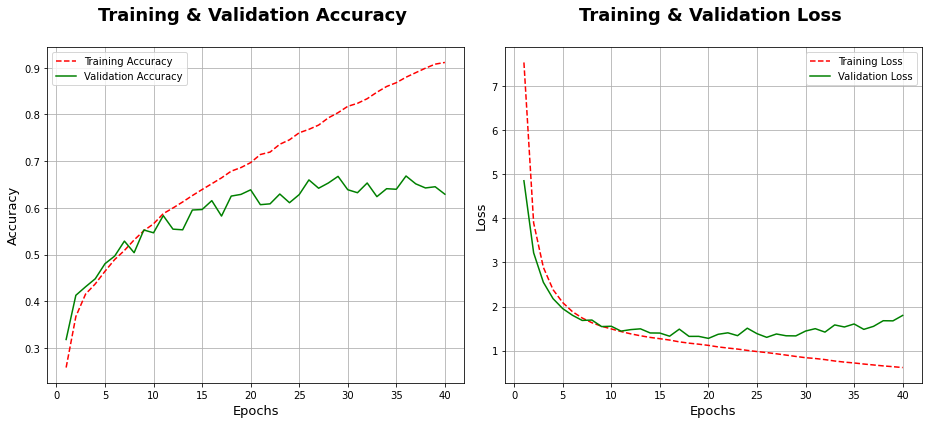

In [14]:
model_plots(cifar_history_3C.history)

In [18]:
# Retrain the regularised model to just before it starts overfitting the training data at 20 epochs:
optimiser = optimizers.RMSprop(learning_rate=1e-04)
cifar_model_3D = conv_model(input_shape=(128,128,3), conv=6, L1_units=50, L2_units=64, L3_units=128, 
                        L4_units=128, L5_units=700, max_pooling=True, regularize='L2', 
                      optimiser=optimiser)

cifar_history_3D = cifar_model_3D.fit(x_train_128, y_train, batch_size=50,
         validation_data = (x_val_128, y_val), epochs=20, shuffle=True)

# Save the model:
cifar_model_3D.save('128_SR_20e_cifar_model_3D_L2.h5')

L1 Pooling
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 123, 123, 50)      5450      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 61, 61, 50)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 56, 64)        115264    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 28, 28, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 23, 23, 128)       295040    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 11, 11, 

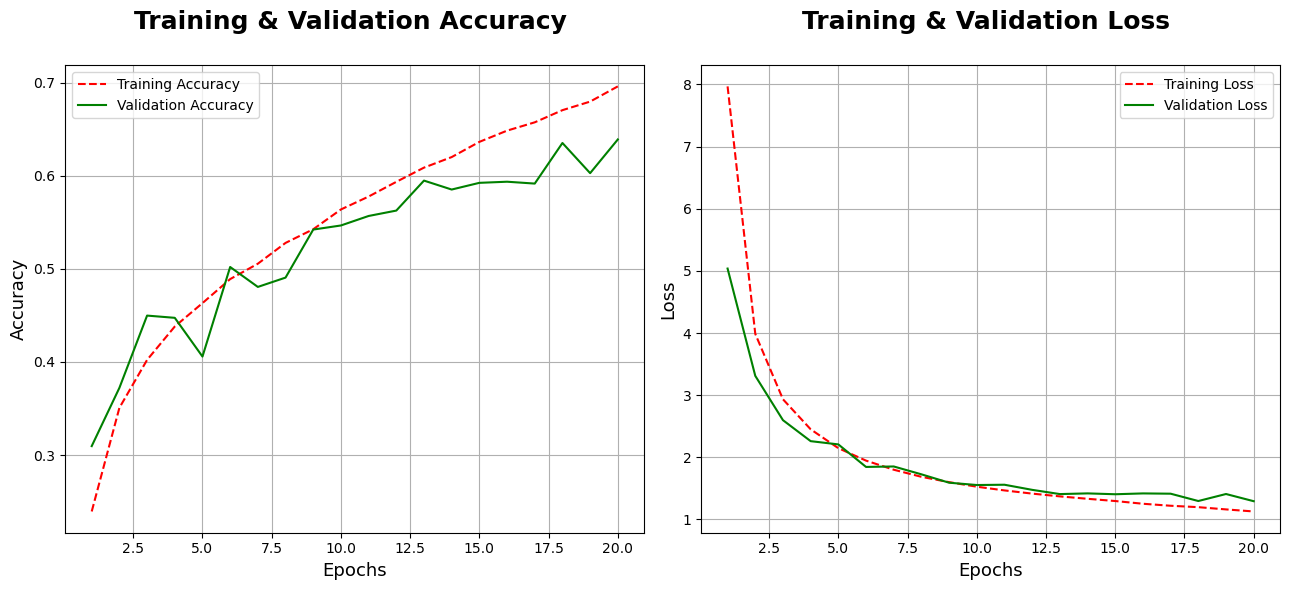

In [19]:
model_plots(cifar_history_3D.history)

In [20]:
cifar_model_3D.evaluate(x_test_128, y_test) # Evaluate on x_test_128 and y_test to verify

313/313 [==============================] - 149s 472ms/step - loss: 1.2947 - acc: 0.6392


[1.2947053909301758, 0.63919997215271]

# 5. Comparison of the Single Best LR and SR Models
The single best LR and SR models will be used to predict the class of the full unseen test data. From this, the precision and recall of the model can be calculated and this should allow a useful comparison to be made between the performance of each model.

## 5.1 Single Best LR Model
The single best LR model is model called "32_LR_59e_cifar_model_1B", as this model resulted in the highest classification accuracy on the test set compared to all other models that were trained on the LR CIFAR-10 data.

In [9]:
from sklearn.metrics import precision_score, accuracy_score, recall_score

def conf_matrix(test_predictions,test_labels):
    test_predictions_list = []
    test_labels_list = []
    for i,j in enumerate(test_predictions):
        test_predictions_list.append(np.argmax(test_predictions[i]))
        test_labels_list.append(np.argmax(test_labels[i]))
    confusion_array = confusion_matrix(y_true = test_labels_list, y_pred = test_predictions_list)
    return confusion_array, test_predictions_list, test_labels_list  

In [12]:
LR_predictions = cifar_model_1B.predict(x_test_32)
LR_pred = np.array(LR_predictions).round(2)
LR_pred_singles = []
for x in LR_pred:
    LR_pred_singles.append(np.argmax(x))
    
# Create the confusion matrix for the LR model predictions:
LR_confusion_array, LR_test_predictions, LR_test_labels = conf_matrix(LR_predictions, y_test)
print("LR Confusion Matrix: \n", LR_confusion_array)

# Extract the class names from the dictionary so that they can be used as axis tick labels:
class_names = []
for i,j in enumerate(cifar10_label_names):
    class_names.append(str(cifar10_label_names[i]))


313/313 [==============================] - 3s 8ms/step
LR Confusion Matrix: 
 [[704  32  43  10  23   8  20  14  88  58]
 [ 42 730  13   2   2  12  25  14  45 115]
 [ 75  21 401  63 115  93 135  57  24  16]
 [ 24  15  62 328  61 217 164  74  28  27]
 [ 32   7  69  46 498  39 129 149  14  17]
 [ 18  11  54 107  47 566  77  95   7  18]
 [  9   8  34  26  31  29 822  17   6  18]
 [ 19   5  22  30  59  75  30 722   8  30]
 [102  47  13  13   9  10   8  10 735  53]
 [ 36 102  14  16   5  10  30  24  54 709]]


In [28]:
LR_true_positives = np.diag(LR_confusion_array)
LR_total_acc = LR_true_positives.sum()/LR_confusion_array.sum()
print("LR_true_posities:", LR_true_positives)
print("LR_total_accuracy:", LR_total_acc)

LR_true_posities: [704 730 401 328 498 566 822 722 735 709]
LR_total_accuracy: 0.6215


The accuracy calculated from the confusion matrix in the above cell corresponds to the accuracy score reported for the model in section 3.1.

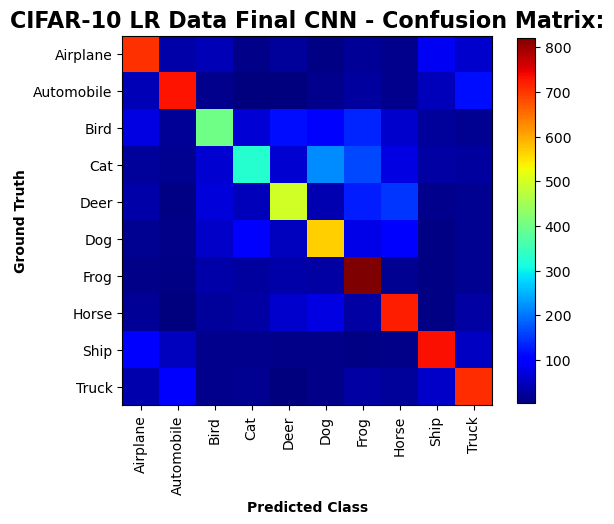

In [15]:
# LR Model Confusion matrix plot:
plt.xlabel('Predicted Class',fontweight="bold")
plt.ylabel('Ground Truth',fontweight="bold")
plt.title("CIFAR-10 LR Data Final CNN - Confusion Matrix:", fontsize = "16", fontweight="bold")
plt.xticks(np.arange(0, 10, 1), labels = class_names, rotation = 90)
plt.yticks(np.arange(0, 10, 1), labels = class_names)
pixel_plot = plt.imshow(LR_confusion_array, cmap="jet", interpolation='nearest')
plt.colorbar(pixel_plot,shrink=0.99)
plt.show()

In [25]:
print("LR Per Class Precision:")
LR_precision = precision_score(y_true = y_test_32, y_pred = LR_pred_singles, average=None).round(2)
print("LR Precision:", LR_precision, ", LR Average:", np.average(LR_precision).round(2))

print("LR Per Class Recall:")
LR_recall = recall_score(y_true = y_test_32, y_pred = LR_pred_singles, average=None).round(2)
print("LR Recall:", recall, ", LR Average:", np.average(LR_recall).round(2))

LR_accuracy = accuracy_score(y_true = y_test_32, y_pred = LR_pred_singles).round(3)
print("LR Overall Accuracy:", LR_accuracy)

LR Per Class Precision:
LR Precision: [0.66 0.74 0.55 0.51 0.59 0.54 0.57 0.62 0.73 0.67] , LR Average: 0.62
LR Per Class Recall:
LR Recall: [0.74 0.75 0.53 0.42 0.61 0.46 0.82 0.67 0.65 0.74] , LR Average: 0.62
LR Overall Accuracy: 0.622


## 5.2 Single Best SR Model
The single best SR model is model called "128_SR_20e_cifar_model_3D_L2", as this model resulted in the highest classification accuracy on the test set compared to all other models that were trained on the SR CIFAR-10 data.

In [18]:
SR_predictions = cifar_model_3D.predict(x_test_128)
SR_pred = np.array(SR_predictions).round(2)
SR_pred_singles = []
for x in SR_pred:
    SR_pred_singles.append(np.argmax(x))
    
# Create the confusion matrix for the SR model predictions:
SR_confusion_array, SR_test_predictions, SR_test_labels = conf_matrix(SR_predictions, y_test)
print("SR Confusion Matrix: \n", SR_confusion_array)

313/313 [==============================] - 144s 460ms/step
SR Confusion Matrix: 
 [[742  27  45  13  23   6  27  14  56  47]
 [ 61 752  10  11   7   7  26   7  22  97]
 [ 78   6 523  63 111  39 109  41  12  18]
 [ 21   7 106 419  81 146 143  37  13  27]
 [ 31   6  94  45 606  22 108  72   6  10]
 [ 16   5 101 181  79 466  78  54   8  12]
 [  5   6  49  38  53  13 818   7   4   7]
 [ 15   4  43  53 111  53  20 675   2  24]
 [185  39  20  17   7  11  15   8 647  51]
 [ 56  83  12  19   7   5  38  14  22 744]]


In [29]:
SR_true_positives = np.diag(SR_confusion_array)
SR_total_acc = SR_true_positives.sum()/SR_confusion_array.sum()
print("SR_true_posities:", SR_true_positives)
print("SR_total_accuracy:", SR_total_acc)

SR_true_posities: [742 752 523 419 606 466 818 675 647 744]
SR_total_accuracy: 0.6392


The accuracy calculated from the confusion matrix in the above cell corresponds to the accuracy score reported for the model in section 4.2.

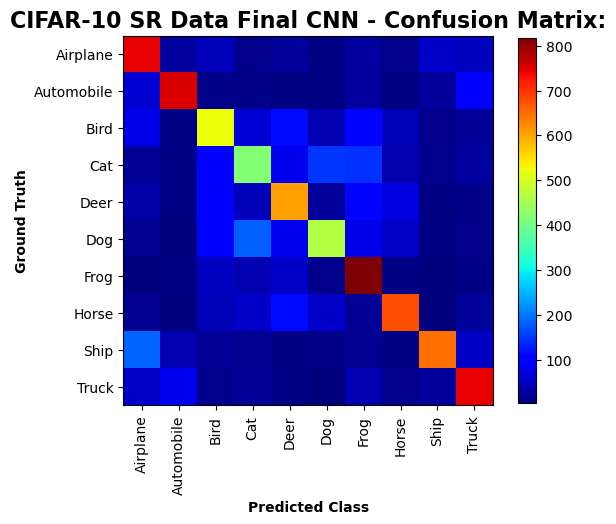

In [19]:
# Confusion matrix plot:
plt.xlabel('Predicted Class',fontweight="bold")
plt.ylabel('Ground Truth',fontweight="bold")
plt.title("CIFAR-10 SR Data Final CNN - Confusion Matrix:", fontsize = "16", fontweight="bold")
plt.xticks(np.arange(0, 10, 1), labels = class_names, rotation = 90)
plt.yticks(np.arange(0, 10, 1), labels = class_names)
pixel_plot = plt.imshow(SR_confusion_array, cmap="jet", interpolation='nearest')
plt.colorbar(pixel_plot,shrink=0.99)
plt.show()

In [31]:
print("SR Per Class Precision:")
precision = precision_score(y_true = y_test_32, y_pred = SR_pred_singles, average=None).round(2)
print("SR Precision:",precision, ", SR Average:",np.average(precision).round(2))

SR Per Class Precision:
SR Precision: [0.61 0.8  0.52 0.49 0.56 0.61 0.6  0.73 0.82 0.72] , SR Average: 0.65


In [30]:
print("SR Per Class Precision:")
precision = precision_score(y_true = y_test_32, y_pred = SR_pred_singles, average=None).round(2)
print("SR Precision:",precision, ", SR Average:",np.average(precision).round(2))

print("SR Per Class Recall:")
recall = recall_score(y_true = y_test_32, y_pred = SR_pred_singles, average=None).round(2)
print("SR Recall:",recall, ", SR Average:",np.average(recall).round(2))

SR_accuracy = accuracy_score(y_true = y_test_32, y_pred = SR_pred_singles).round(3)
print("SR Overall Accuracy:", SR_accuracy)

SR Per Class Precision:
SR Precision: [0.61 0.8  0.52 0.49 0.56 0.61 0.6  0.73 0.82 0.72] , SR Average: 0.65
SR Per Class Recall:
SR Recall: [0.74 0.75 0.53 0.42 0.61 0.46 0.82 0.67 0.65 0.74] , SR Average: 0.64
SR Overall Accuracy: 0.639


# 6. Downloading of Output H5 Trained Model Files
The code in this section will allow the trained h5 models to be downloaded from this notebook environment.

In [24]:
import os
from IPython.display import FileLink
os.chdir(r'/kaggle/working')

In [38]:
FileLink(r'32_LR_58e_cifar_model_2B.h5')

/kaggle/working/32_LR_58e_cifar_model_2B.h5